## Metroplis sampling from a distribution 
study group tutorial 16jan19 / jplewis

In [10]:
using Distributions

Using the Distributions Beta() function here. At first glance this might seem circular - if this function already exists, why not just use it. However, note that Beta() will be called with a sample (location) and returns its probability, whereas Metropolis sampling produces sample locations that are consistent with the probability density. In one dimension this could also be done by indirecting a U(0,1) random number through the inverse CDF, howver Metropolis sampling is easier, especially in high dimensions. 
A bigger advantage occurs when drawing samples from a posterior. In that case, computing the denominator p(x) is usually impractical, however when a probability scaled by an unknown constant is used in the Metropolis procedure, the constant cancels in the ratio (in mcmc1() below).


In [11]:
# the distribution to sample from
beta = Distributions.Beta(5.,2.)
function prob(a) 
    return Distributions.pdf(beta, a)
end
probmin,probmax = (0.,1.)

(0.0, 1.0)

Pick a new sample location (on the "x axis")
Evaluate the probability there. If higher than probability at previous location, accept.
Otherwise accept with probability p(new)/p(old).

Be sure to keep straight: the sample _location_ versus its probability.  

In [19]:
function mcmc1(a,explore)

    clamp(a,lo,hi) = a < lo ? lo : a > hi ? hi : a	# support of beta distribution is 0,1
    
    proba = prob(a)
    for mciter = 1:100
        # note the scale makes a big difference.  too big and it spends too much time sampling the tails,
        # the histogram is not high enough near the mode.
        a_ = a + explore * randn()		# todo switch to heavy-tailed/t distribution
        a_ = clamp(a_,probmin,probmax)
        p = prob(a_) / proba
        if (rand() < p)
            return a_
        end
    end
    return a
end

mcmc1 (generic function with 1 method)

In [20]:

function burnin(A,explore=0.01)
    for i=1:10000
        A = mcmc1(A,explore)
    end
    A
end    

function mcmc(A,samples,explore=0.01)
    nsamples = length(samples)
    for i=1:nsamples
        A = mcmc1(A,explore)
        samples[i] = A
    end
    A
end

mcmc (generic function with 2 methods)

In [21]:
Nsamples = 1000000
Samples = Array{Float64}(undef,Nsamples)

s = 1.0
s = burnin(s)
s = mcmc(s,Samples)
#Samples = Samples / sum(Samples)

0.877228795807355

In [22]:

using PyPlot
p_ = PyPlot
p_.clf()

# plot the true distribution, !scaled to match the histogram
npts = 100
y = zeros(npts)
x = range(0., stop=1., length=npts)
for i=1:npts
    y[i] = Distributions.pdf(beta,x[i])
end
#p_.plot(x,y,"k-")		# scale height of curve to match

# plot the histogram
#p_.plt[:hist](Samples, bins="auto")

In [16]:

function mkhist(samples, npts)
    hist = zeros(npts)
    nsamples = length(samples)
    themin = minimum(samples)
    themax = maximum(samples)
    scale = (npts-0.01) / (themax - themin)
    for i=1:nsamples
        s = samples[i]
        s = scale * (s - themin)
        @assert s >= 0. && s <= npts
        idx = floor(Int,s)
        @assert idx >= 0 && idx < npts
        idx = idx + 1
        hist[idx] = hist[idx]+1
    end
    hist = hist ./ sum(hist)
    x = range(themin, stop=themax, length=npts)
    return (x,hist)
end

mkhist (generic function with 1 method)

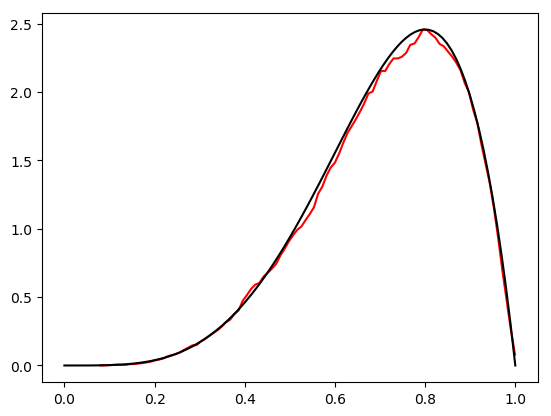

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x1470eb588>

In [23]:
xh,hist = mkhist(Samples,npts)
hscale = maximum(y)/maximum(hist)
p_.plot(xh,hscale .* hist,"r-")
p_.plot(x,y,"k-")		# scale height of curve to match

### depends heavily on exploration parameter!

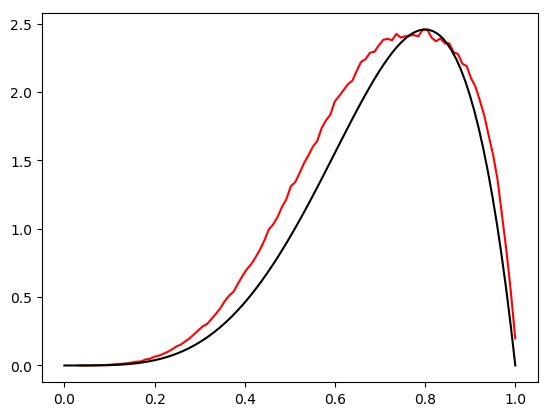

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x13e79d7b8>

In [24]:
s = 1.0
s = burnin(s)
s = mcmc(s,Samples,0.5)

xh,hist = mkhist(Samples,npts)
hscale = maximum(y)/maximum(hist)
p_.plot(xh,hscale .* hist,"r-")
p_.plot(x,y,"k-")		# scale height of curve to match